<a href="https://colab.research.google.com/github/KacaPopovic/Minimal-GAN/blob/main/colab_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [3]:
##load  MNIST
# Samples
Nsamples = 100
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_loader_train = torch.utils.data.DataLoader(mnist_train, batch_size=Nsamples,shuffle=True)

mnist_test = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
mnist_loader_test = torch.utils.data.DataLoader(mnist_test, batch_size=Nsamples, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 37636828.91it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1053280.59it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 6205364.72it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 13539821.44it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
# Define the generator
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

In [5]:
# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        logit = self.fc2(x)
        prob = self.sigmoid(logit)
        return logit, prob

In [9]:
# Noise dimensions
zdim = 50
# Initialize models
G = Generator(zdim, 784).cuda()
D = Discriminator(784).cuda()

# Optimizers
lr = 0.0002
G_opt = torch.optim.Adam(G.parameters(), lr=lr)
D_opt = torch.optim.Adam(D.parameters(), lr=lr)
# Generate samples
def draw_sample(m, n):
    return np.random.uniform(-1.0, 1.0, size=[m, n])

# Loss function
criterion = nn.BCELoss()
num_epochs = int(1e3)
# Samples
Nsamples = 100

# Lists to store losses
D_losses = []
G_losses = []

for epoch in range(num_epochs):
    for imgs, _ in mnist_loader_train:
        imgs = imgs.view(-1, 784).cuda()
        batch_size = imgs.size(0)

        z = torch.Tensor(draw_sample(Nsamples, zdim)).cuda()
        real_labels = torch.ones(Nsamples,1).cuda()
        fake_labels = torch.zeros(Nsamples,1).cuda()

        D_real_logit, D_real_prob = D(imgs)
        G_sample = G(z)

        D_fake_logit, D_dake_prob = D(G_sample.detach())

        # 1. Update the discriminator using real and generated samples

        D_loss_real = criterion(D_real_prob, real_labels)
        D_loss_fake = criterion(D_dake_prob, fake_labels)
        D_loss = D_loss_real + D_loss_fake

        D_opt.zero_grad()
        D_loss.backward()
        D_opt.step()

        # 2. Update the generator

        G_fake_logit, G_fake_prob = D(G_sample)
        G_loss = criterion(G_fake_prob, real_labels)

        G_opt.zero_grad()
        G_loss.backward()
        G_opt.step()

        # Save losses
        D_losses.append(D_loss.item())
        G_losses.append(G_loss.item())

    if epoch % int(1e2) == 0:
        print('Epoch {}, Discriminator Loss {:.3f}, Generator Loss {:.3f}'.format(epoch, D_loss.item(), G_loss.item()))

Epoch 0, Discriminator Loss 0.199, Generator Loss 2.810
Epoch 100, Discriminator Loss 0.472, Generator Loss 2.608
Epoch 200, Discriminator Loss 0.596, Generator Loss 2.387
Epoch 300, Discriminator Loss 0.438, Generator Loss 2.628
Epoch 400, Discriminator Loss 0.500, Generator Loss 2.458
Epoch 500, Discriminator Loss 0.418, Generator Loss 2.468
Epoch 600, Discriminator Loss 0.522, Generator Loss 2.341
Epoch 700, Discriminator Loss 0.432, Generator Loss 2.451
Epoch 800, Discriminator Loss 0.371, Generator Loss 2.396
Epoch 900, Discriminator Loss 0.375, Generator Loss 2.237


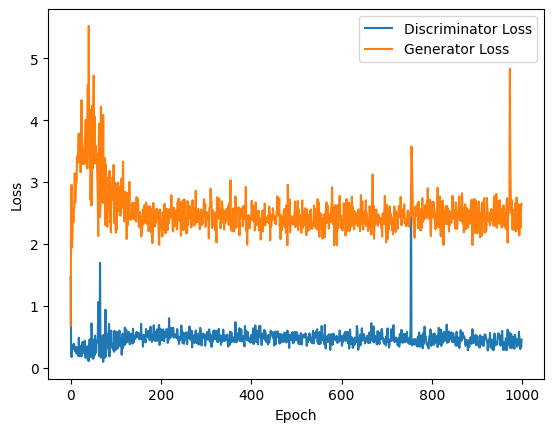

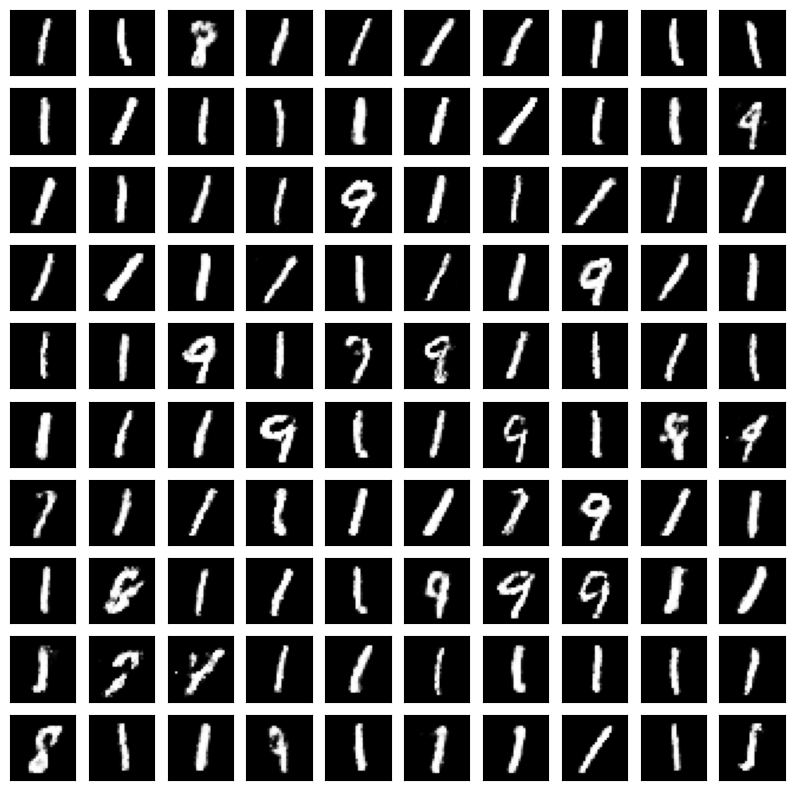

In [14]:
#plot losses and generated images
import os

# Assuming you know the number of batches per epoch
num_batches_per_epoch = len(mnist_loader_train)

# Select every N-th loss
D_losses_epoch = D_losses[::num_batches_per_epoch]
G_losses_epoch = G_losses[::num_batches_per_epoch]

# Plot the losses
plt.figure()
plt.plot(D_losses_epoch, label='Discriminator Loss')
plt.plot(G_losses_epoch, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
# Generate and plot final images

z = torch.Tensor(draw_sample(100, zdim)).cuda()
G_sample_inf = G(z)
samples = G_sample_inf.detach().cpu().numpy()

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(10, 10)
for j, sample in enumerate(samples):
    ax = plt.subplot(gs[j])
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

if not os.path.exists('res'):
    os.makedirs('res')
plt.savefig('res/final_generated_images.png', bbox_inches='tight')
plt.show()